In [1]:
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt

In [2]:
repo_path = "/media/pedro-lima/HDD/github/heuristics-fsmp"

In [3]:
def plot_history(folder_path, title):

    all_files = glob.glob(folder_path + "/*.csv") # read all csv files in the folder

    dfs = []
    file_names = []
    for file in all_files:
        if "debug" in file:
            continue
        df = pd.read_csv(file)
        dfs.append(df)
        file_names.append(file.split('/')[-1])  # get the file name

    fig, ax = plt.subplots()
    for df, name in zip(dfs, file_names):
        df["generation"] = range(1, len(df) + 1)  # generation column
        df.plot(x="generation", y="fitness_history", kind="line", ax=ax, label=name)

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(labels, handles), key=lambda x: x[0])
    labels, handles = zip(*sorted_labels_handles)
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.xlabel("generation")
    plt.ylabel("negative_log_likelihood")
    plt.title(title)
    plt.grid()
    plt.show()

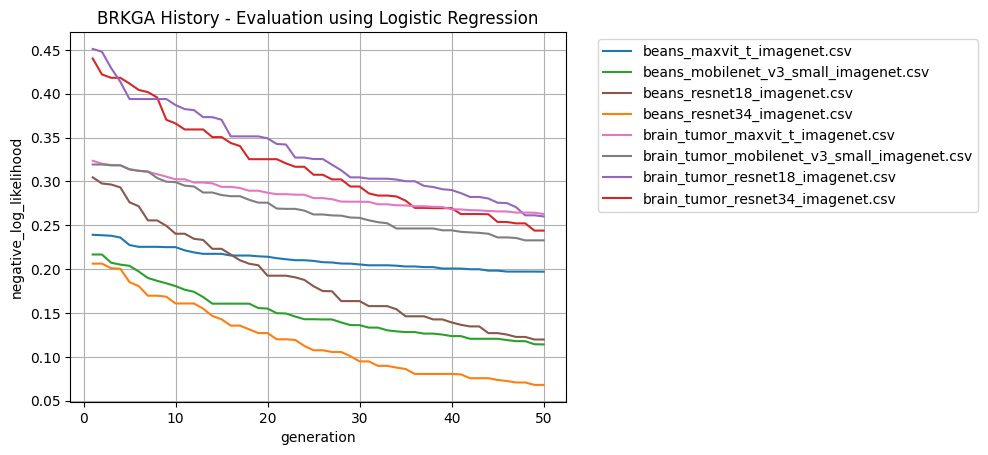

In [4]:
folder_path = f"{repo_path}/log/history_LW_LR"
plot_history(folder_path, "BRKGA History - Evaluation using Logistic Regression")

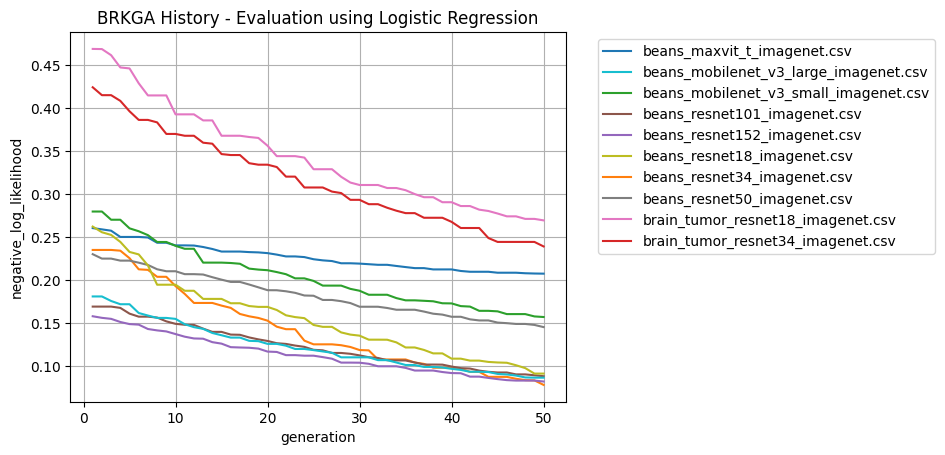

In [13]:
folder_path = f"{repo_path}/log/history_imagenet"
plot_history(folder_path, "BRKGA History - Evaluation using Logistic Regression")

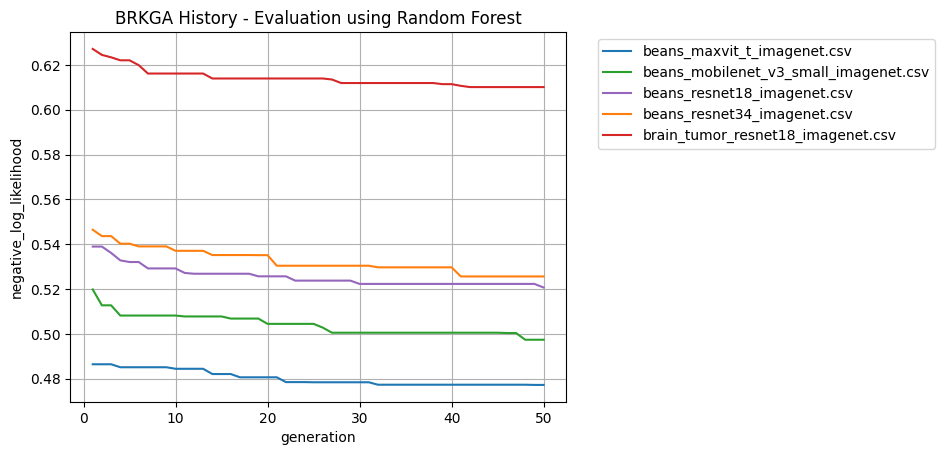

In [14]:
folder_path = f"{repo_path}/log/history_LW_RF"
plot_history(folder_path, "BRKGA History - Evaluation using Random Forest")

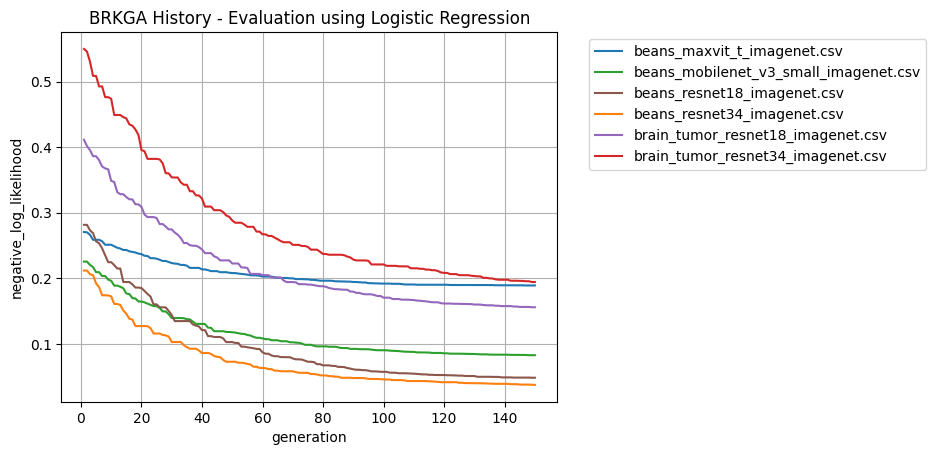

In [15]:
folder_path = f"{repo_path}/log/history_150"
plot_history(folder_path, "BRKGA History - Evaluation using Logistic Regression")

In [16]:
def show_table(file_path):
    df = pd.read_csv(file_path)

    # filter and calculate the mean for random features
    random_features_mean = (
        df[df['feature selection'] == 'random features']
        .groupby(['dataset', 'model', 'weights', 'n_features_model', 'selected_features', 'feature selection'])
        [['accuracy', 'f1', 'precision', 'recall', 'roc_auc']]
        .mean()
        .reset_index()
    )

    # combine random features mean with other methods
    non_random_features = df[df['feature selection'] != 'random features']
    combined = pd.concat([non_random_features, random_features_mean])

    # fill NA in 'feature_selection' column
    combined['selected_features'] = combined.groupby(['dataset', 'model', 'weights'])['selected_features'].transform(
        lambda x: x.fillna(method='ffill').fillna(method='bfill')  # forward and backward fill within the group
    )
    combined["selected_features"] = combined["selected_features"].astype(int)

    group_keys = ['dataset', 'model', 'weights', 'n_features_model', 'selected_features']
    table = (
        combined
        .pivot_table(
            index=group_keys,
            columns='feature selection',
            values=['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
        )
        .reset_index()
    )

    table.columns = pd.MultiIndex.from_tuples(
        [(metric, feature) for metric, feature in table.columns]
    )

    table = table.reset_index(drop=True)

    def style_columns(dataframe):
        colors = {
            'accuracy': {'background-color': '#ffffff', 'color': 'black'},
            'f1': {'background-color': '#cccccc', 'color': 'black'},
            'precision': {'background-color': '#ffffff', 'color': 'black'},
            'recall': {'background-color': '#cccccc', 'color': 'black'},
            'roc_auc': {'background-color': '#ffffff', 'color': 'black'},
        }
        style_df = pd.DataFrame('', index=dataframe.index, columns=dataframe.columns)
        
        for metric, style in colors.items():
            style_df.loc[:, metric] = f"background-color: {style['background-color']}; color: {style['color']};"
        
        return style_df

    # Apply the column colors
    styled_table = table.style.apply(style_columns, axis=None)
    styled_table = styled_table.format(precision=4)

    # Display the styled table
    display(styled_table)

In [17]:
file_path = f"{repo_path}/log/evaluation_results_imagenet.csv"
show_table(file_path)

/tmp/ipykernel_72942/891261823.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')  # forward and backward fill within the group


In [18]:
file_path = f"{repo_path}/log/evaluation_results_LW_LR.csv"
show_table(file_path)

/tmp/ipykernel_72942/891261823.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')  # forward and backward fill within the group


In [19]:
file_path = f"{repo_path}/log/evaluation_results_150.csv"
show_table(file_path)

/tmp/ipykernel_72942/891261823.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')  # forward and backward fill within the group
